In [1]:
!wget https://github.com/callummcdougall/sae_visualizer/archive/refs/heads/main.zip
!unzip main.zip

from pathlib import Path
root = Path("sae_visualizer-main").rename("sae_visualizer")
%pip install git+https://github.com/callummcdougall/eindex.git

import os, sys
os.remove("main.zip")
sys.path.append("sae_visualizer")


from IPython.display import display, HTML, clear_output
clear_output()

--2024-02-01 11:36:17--  https://github.com/callummcdougall/sae_visualizer/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/callummcdougall/sae_visualizer/zip/refs/heads/main [following]
--2024-02-01 11:36:17--  https://codeload.github.com/callummcdougall/sae_visualizer/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ] 442.93K  --.-KB/s    in 0.08s   

2024-02-01 11:36:18 (5.39 MB/s) - ‘main.zip’ saved [453561]

Archive:  main.zip
43d8d442851b41587710506b65c0258a60e3e231
   creating: sae_visualizer-main/
  inflating: sae_vis

OSError: [Errno 39] Directory not empty: 'sae_visualizer-main' -> 'sae_visualizer'

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
sys.path.append("sae_visualizer")

In [2]:
from transformer_lens import HookedTransformer, utils
import torch
from datasets import load_dataset
from typing import Dict
from tqdm.notebook import tqdm
import plotly.express as px
import json

from sae_visualizer.model_fns import AutoEncoderConfig, AutoEncoder
from sae_visualizer.data_fns import get_feature_data, FeatureData

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_grad_enabled(False)

def imshow(x, **kwargs):
    x_numpy = utils.to_numpy(x)
    px.imshow(x_numpy, **kwargs).show()

In [3]:
import pprint
import time
import gzip
import json
import numpy as np
from pathlib import Path
from typing import List
from dataclasses import dataclass
from transformer_lens import utils, HookedTransformer
from transformer_lens.hook_points import HookPoint
import torch
from torch import Tensor
from eindex import eindex
from IPython.display import display, HTML
from typing import Optional, List, Dict, Callable, Tuple, Union, Literal
from dataclasses import dataclass
import torch.nn.functional as F
import torch.nn as nn
import einops
from jaxtyping import Float, Int
from collections import defaultdict
from functools import partial
from rich import print as rprint
from rich.table import Table
import pickle
import os
from sae_visualizer.utils_fns import sample_unique_indices, TopK, k_largest_indices, random_range_indices, reshape, to_str_tokens

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

In [4]:
from SAETrainer import SAETrainer
import wandb

api = wandb.Api()
run = api.run("mega-alignment/sae/9jyap5cc")  # this is the q-l9h9 sae with low l0
cfg = run.config
artifact_dir = api.artifact("georglange/serimats/model-9jyap5cc:v1").download()

encoder = SAETrainer.load_from_checkpoint(os.path.join(artifact_dir, 'model.ckpt'), cfg, ).sae
encoder.cfg['concat_heads'] = True if encoder.cfg['head'] == 'cat' else False
#encoder.cfg['seq_len'] = 128
encoder.cfg['extraction_batch_size'] = 20
encoder.cfg['buffer_size'] = 1e6
cfg

wandb:   1 of 1 files downloaded.  


{'lr': 0.001,
 'head': 9,
 'layer': 9,
 'seq_len': 512,
 'd_hidden': 8192,
 'actv_name': 'blocks.9.attn.hook_q',
 'actv_size': 64,
 'ckpt_name': 'q-l9h9-l1_0.7-819.2M.ckpt',
 'batch_size': 2048,
 'wandb_name': 'q--l9h9-l1_0.7-819.2M',
 'buffer_size': 1000000.0,
 'train_steps': 400000,
 'dataset_name': 'Skylion007/openwebtext',
 'l1_coefficient': 0.7,
 'language_model': 'gpt2-small',
 'lr_warmup_steps': 3000,
 'resampling_steps': [50000, 100000, 150000, 200000],
 'n_resampler_samples': 819200,
 'extraction_batch_size': 20,
 'init_geometric_median': False,
 'standardize_activations': True,
 'n_resampling_watch_steps': 5000,
 'reconstruction_loss_batch_size': 16,
 'concat_heads': False}

In [5]:
def sanity_check(ckpt_path, cfg, encoder):
 
    import text_dataset
    from text_dataset import TextDataset
    from torch.utils.data import DataLoader
    from activation_buffer import Buffer
    from metrics.reconstruction_loss import ReconstructionLoss
    import pytorch_lightning as pl
    
    dataset = load_dataset(cfg['dataset_name'], split='train')
    if 'TinyStories' in str(dataset) or 'pile' in str(dataset):
        dataset = dataset['train']
    dataset = dataset.shuffle()
    
    llm = HookedTransformer.from_pretrained(
        model_name='gpt2-small',
        # refactor_factored_attn_matrices=True,
        device='cpu'  # will be moved to GPU later by lightning
    )
    llm.requires_grad_(False)
    
    token_dataset = TextDataset(dataset, llm.to_tokens, encoder.cfg['extraction_batch_size'], drop_last_batch=False,
                                seq_len=encoder.cfg['seq_len'])
    
    text_dataset_loader = iter(DataLoader(token_dataset, batch_size=None, shuffle=False, num_workers=5,
                                          prefetch_factor=5, worker_init_fn=text_dataset.worker_init_fn))
    
    buffer_size = cfg['buffer_size']
    cfg['buffer_size'] = 1e5
    buffer = Buffer(
        llm.cuda(),
        text_dataset_loader,
        **cfg
    )
    cfg['buffer_size'] = buffer_size
    loader = torch.utils.data.DataLoader(buffer, batch_size=None, shuffle=False, num_workers=0)
    
    reconstruction_loss_metric_zero = ReconstructionLoss(llm, encoder,
                                                TextDataset(dataset, llm.to_tokens,
                                                            cfg['reconstruction_loss_batch_size'],
                                                            drop_last_batch=False,
                                                            seq_len=cfg['seq_len'])
                                                , cfg['actv_name'],
                                                cfg['head'], ablation_type='zero')
    reconstruction_loss_metric_mean = ReconstructionLoss(llm, encoder,
                                                TextDataset(dataset, llm.to_tokens,
                                                            cfg['reconstruction_loss_batch_size'],
                                                            drop_last_batch=False,
                                                            seq_len=cfg['seq_len'])
                                                , cfg['actv_name'],
                                                cfg['head'], ablation_type='mean')
    
    encoder_trainer = SAETrainer.load_from_checkpoint(ckpt_path, cfg, reconstruction_loss_metric_mean=reconstruction_loss_metric_mean,
                                                     reconstruction_loss_metric_zero=reconstruction_loss_metric_zero)
    trainer = pl.Trainer(devices=[0], max_steps=cfg['train_steps'], #logger=wandb_logger,
                         val_check_interval=2000, limit_val_batches=5, limit_test_batches=5,
                        #callbacks=[checkpoint_callback]
                         )
    from IPython.display import display, HTML, clear_output
    clear_output()
    trainer.test(encoder_trainer, loader)

In [6]:
state_dict = torch.load(os.path.join(artifact_dir, 'model.ckpt'), map_location='cpu')['state_dict']
encoder.standard_norm, state_dict['sae.standard_norm']

(Parameter containing:
 tensor(9.9803, device='cuda:0'),
 tensor(9.9803))

In [14]:
sanity_check(os.path.join(artifact_dir, 'model.ckpt'), cfg, encoder)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_l0_loss          │        7.14794921875         │
│            val_l1            │     0.00286419247277081      │
│           val_loss           │      0.547965407371521       │
│           val_mse            │      0.5451012849807739      │
│ val_reconstruction_loss_mean │      0.3289094567298889      │
│ val_reconstruction_loss_zero │      0.8259336352348328      │
└──────────────────────────────┴──────────────────────────────┘

In [117]:
def get_batch_tokens(dataset_iter, batch_size, model, cfg):
    tokens = []
    total_tokens = 0
    while total_tokens < batch_size*cfg["seq_len"]:
        try:
            # Retrieve next item from iterator
            row = next(dataset_iter)["text"]
        except StopIteration:
            # Break the loop if dataset ends
            break

        # Tokenize the text with a check for max_length
        cur_toks = model.to_tokens(row)
        tokens.append(cur_toks)

        total_tokens += cur_toks.numel()

    # Check if any tokens were collected
    if not tokens:
        return None

    # Depending on your model's tokenization, you might need to pad the tokens here

    # Flatten the list of tokens
    flat_tokens = torch.cat(tokens, dim=-1).flatten()
    flat_tokens = flat_tokens[:batch_size * cfg["seq_len"]]
    reshaped_tokens = einops.rearrange(
        flat_tokens,
        "(batch seq_len) -> batch seq_len",
        batch=batch_size,
    )
    reshaped_tokens[:, 0] = model.tokenizer.bos_token_id
    return reshaped_tokens

def get_per_src_pos_dfa_all_heads(tokens, feature_id, encoder, model):
    _, cache = model.run_with_cache(tokens)
    layer = encoder.cfg["layer"]
    v = cache["v", layer] # [batch, src_pos, n_heads, d_head]
    if type(encoder.cfg['head']) == int:
        v_cat = v[:, :, encoder.cfg['head'], :]
    else:
        v_cat = einops.rearrange(v, "batch src_pos n_heads d_head -> batch src_pos (n_heads d_head)") # [batch, src_pos, n_heads*d_head]

    attn_weights = cache['pattern', layer]  # [batch, n_heads, dest_pos, src_pos]
    if type(encoder.cfg['head']) == int:
        attn_weights = attn_weights[:, encoder.cfg['head'], :, :].view(attn_weights.shape[0], 1, attn_weights.shape[2], attn_weights.shape[3])
    attn_weights_bcast = einops.repeat(attn_weights, "batch n_heads dest_pos src_pos -> batch dest_pos src_pos (n_heads d_head)", d_head=model.cfg.d_head)  # [batch, dest_pos, src_pos, n_heads*d_head]

    # Element-wise multiplication, removing the loop
    decomposed_z_cat = attn_weights_bcast * v_cat.unsqueeze(1)  # [batch, dest_pos, src_pos n_heads*d_head]

    per_src_pos_dfa = einops.einsum(
        decomposed_z_cat, encoder.W_enc[:, feature_id],
        "batch dest_pos src_pos d_model, d_model -> batch dest_pos src_pos",
    )
    return per_src_pos_dfa

@dataclass
class MinimalSequenceData:
    '''
    Class to store data for a given sequence, which will be turned into a JavaScript visulisation.
    Basically just wraps token_ids and the corresponding feature acts for some (prompt, feature_id) pair

    Before hover:
        str_tokens: list of string tokens in the sequence
        feat_acts: sizes of activations on this sequence

    '''
    token_ids: List[str]
    feat_acts: List[float]

    def __len__(self):
        return len(self.token_ids)

    def __str__(self):
        return f"MinimalSequenceData({''.join(self.token_ids)})"

    def _filter(self, float_list: List[List[float]], int_list: List[List[str]]):
        float_list = [[f for f in floats if f != 0] for floats in float_list]
        int_list = [[i for i, f in zip(ints, floats)] for ints, floats in zip(int_list, float_list)]
        return float_list, int_list


class MinimalSequenceDataBatch:
    '''
    Class to store a list of MinimalSequenceData objects at once, by passing in tensors or objects
    with an extra dimension at the start.

    Note, I'll be creating these objects by passing in objects which are either 2D (k seq_len)
    or 3D (k seq_len top5), but which are all lists (of strings/ints/floats).

    '''
    def __init__(self, **kwargs):
        self.seqs = [
            MinimalSequenceData(
                token_ids = kwargs["token_ids"][k],
                feat_acts = kwargs["feat_acts"][k],
            )
            for k in range(len(kwargs["token_ids"]))
        ]

    def __getitem__(self, idx: int) -> MinimalSequenceData:
        return self.seqs[idx]

    def __len__(self) -> int:
        return len(self.seqs)

    def __str__(self) -> str:
        return "\n".join([str(seq) for seq in self.seqs])


@torch.inference_mode()
def get_max_act_indices(
    encoder: AutoEncoder,
    model: HookedTransformer,
    tokens: Int[Tensor, "batch seq"],
    feature_idx: Union[int, List[int]],
    max_batch_size: Optional[int] = None,
    first_group_size: int = 20,
    verbose: bool = False,
):
    '''
    Gets (batch, pos) indices of the top activations for a given feature (or list of features)

    Args:
        feature_idx: int
            The identity of the feature we're looking at (i.e. we slice the weights of the encoder). A list of
            features is accepted (the result will be a list of FeatureData objects).
        max_batch_size: Optional[int]
            Optionally used to chunk the tokens, if it's a large batch

        buffer: Tuple[int, int]
            The number of tokens on either side of the feature, for the right-hand visualisation.

    Returns list of dictionaries that contain SequenceBatchData for each feature (see that class's docstring for more info).
    '''
    model.reset_hooks(including_permanent=True)

    # Make feature_idx a list, for convenience
    if isinstance(feature_idx, int): feature_idx = [feature_idx]
    n_feats = len(feature_idx)

    # Chunk the tokens, for less memory usage
    all_tokens = (tokens,) if max_batch_size is None else tokens.split(max_batch_size)
    all_tokens = [tok.to(device) for tok in all_tokens]

    # Create lists to store data, which we'll eventually concatenate
    all_feat_acts = []

    # Get encoder & decoder directions
    feature_act_dir = encoder.W_enc[:, feature_idx] # (d_mlp, feats)
    feature_bias = encoder.b_enc[feature_idx] # (feats,)
    #assert feature_act_dir.T.shape == feature_out_dir.shape #== (len(feature_idx), encoder.cfg.d_mlp)

    # ! Define hook function to perform feature ablation
    def hook_fn_act_post(act: Float[Tensor, "batch seq act_size"], hook: HookPoint):
        '''
        Encoder has learned x^j \approx b + \sum_i f_i(x^j)d_i where:
            - f_i are the feature activations
            - d_i are the feature output directions

        This hook function stores all the information we'll need later on. It doesn't actually perform feature ablation, because
        if we did this, then we'd have to run a different fwd pass for every feature, which is super wasteful! But later, we'll
        calculate the effect of feature ablation,  i.e. x^j <- x^j - f_i(x^j)d_i for i = feature_idx, only on the tokens we care
        about (the ones which will appear in the visualisation).
        '''
        if encoder.cfg["concat_heads"]:
            act = einops.rearrange(
                act, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
            )
        elif type(encoder.cfg['head']) == int:
            act = act[:, :, encoder.cfg['head'], :]
        feat_acts = encoder.encoder(act)[:, :, feature_idx] # [batch seq features]
        #x_cent = act - encoder.b_dec
        #feat_acts_pre = einops.einsum(x_cent, feature_act_dir, "batch seq act_size, act_size feats -> batch seq feats")
        #feat_acts = F.relu(feat_acts_pre + feature_bias)
        all_feat_acts.append(feat_acts)

    for _tokens in all_tokens:
        model.run_with_hooks(_tokens, return_type=None, fwd_hooks=[
            (encoder.cfg["actv_name"], hook_fn_act_post),
        ])

    # Stack the results, and check shapes
    feat_acts = torch.concatenate(all_feat_acts) # [batch seq feats]
    assert feat_acts[:, :-1].shape == tokens[:, :-1].shape + (len(feature_idx),)

    iterator = range(n_feats) if not(verbose) else tqdm.tqdm(range(n_feats), desc="Getting sequence data", leave=False)

    indices_list = []
    for feat in iterator:

        _feat_acts = feat_acts[..., feat] # [batch seq]

        indices = k_largest_indices(_feat_acts, k=first_group_size, largest=True)
        indices_list.append(indices)

    return indices_list

@torch.inference_mode()
def get_seq_data(
    encoder: AutoEncoder,
    model: HookedTransformer,
    tokens: Int[Tensor, "batch seq"],
    feature_idx: Union[int, List[int]],
    max_batch_size: Optional[int] = None,

    buffer: Tuple[int, int] = (5, 5),
    n_groups: int = 10,
    first_group_size: int = 20,
    other_groups_size: int = 5,
    verbose: bool = False,

):
    '''
    Gets data that will be used to create the sequences in the HTML visualisation.

    Args:
        feature_idx: int
            The identity of the feature we're looking at (i.e. we slice the weights of the encoder). A list of
            features is accepted (the result will be a list of FeatureData objects).
        max_batch_size: Optional[int]
            Optionally used to chunk the tokens, if it's a large batch

        buffer: Tuple[int, int]
            The number of tokens on either side of the feature, for the right-hand visualisation.

    Returns list of dictionaries that contain SequenceBatchData for each feature (see that class's docstring for more info).
    '''
    model.reset_hooks(including_permanent=True)

    # Make feature_idx a list, for convenience
    if isinstance(feature_idx, int): feature_idx = [feature_idx]
    n_feats = len(feature_idx)

    # Chunk the tokens, for less memory usage
    all_tokens = (tokens,) if max_batch_size is None else tokens.split(max_batch_size)
    all_tokens = [tok.to(device) for tok in all_tokens]

    # Create lists to store data, which we'll eventually concatenate
    all_feat_acts = []

    # Get encoder & decoder directions
    feature_act_dir = encoder.W_enc[:, feature_idx] # (d_mlp, feats)
    feature_bias = encoder.b_enc[feature_idx] # (feats,)
    #assert feature_act_dir.T.shape == feature_out_dir.shape #== (len(feature_idx), encoder.cfg.d_mlp)

    # ! Define hook function to perform feature ablation
    def hook_fn_act_post(act: Float[Tensor, "batch seq act_size"], hook: HookPoint):
        '''
        Encoder has learned x^j \approx b + \sum_i f_i(x^j)d_i where:
            - f_i are the feature activations
            - d_i are the feature output directions

        This hook function stores all the information we'll need later on. It doesn't actually perform feature ablation, because
        if we did this, then we'd have to run a different fwd pass for every feature, which is super wasteful! But later, we'll
        calculate the effect of feature ablation,  i.e. x^j <- x^j - f_i(x^j)d_i for i = feature_idx, only on the tokens we care
        about (the ones which will appear in the visualisation).
        '''
        if encoder.cfg["concat_heads"]:
            act = einops.rearrange(
                act, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
            )
        elif type(encoder.cfg['head']) == int:
            act = act[:, :, encoder.cfg['head'], :]
        feat_acts = encoder.encoder(act)[:, :, feature_idx] # [batch seq features]
        #x_cent = act - encoder.b_dec
        #feat_acts_pre = einops.einsum(x_cent, feature_act_dir, "batch seq act_size, act_size feats -> batch seq feats")
        #feat_acts = F.relu(feat_acts_pre + feature_bias)
        all_feat_acts.append(feat_acts)

    # ! Run the forward passes (triggering the hooks), concat all results

    # Run the model without hook (to store all the information we need, not to actually return anything)
    for _tokens in all_tokens:
        model.run_with_hooks(_tokens, return_type=None, fwd_hooks=[
            (encoder.cfg["actv_name"], hook_fn_act_post),
        ])

    # Stack the results, and check shapes
    feat_acts = torch.concatenate(all_feat_acts) # [batch seq feats]
    assert feat_acts[:, :-1].shape == tokens[:, :-1].shape + (len(feature_idx),)

    # ! Calculate all data for the right-hand visualisations, i.e. the sequences
    # TODO - parallelize this (it could probably be sped up by batching indices & doing all sequences at once, although those would be large tensors)
    # We do this in 2 steps:
    #   (1) get the indices per group, from the feature activations, for each of the 12 groups (top, bottom, 10 quantiles)
    #   (2) get a batch of SequenceData objects per group. This usually involves using eindex (i.e. indexing into the `tensors`
    #       tensor with the group indices), and it also requires us to calculate the effect of ablations (using feature activations
    #       and the clean residual stream values).

    sequence_data_list = []

    iterator = range(n_feats) if not(verbose) else tqdm.tqdm(range(n_feats), desc="Getting sequence data", leave=False)

    for feat in iterator:

        _feat_acts = feat_acts[..., feat] # [batch seq]

        k_largest_thing = k_largest_indices(_feat_acts, k=first_group_size, largest=True)

        # (1)
        indices_dict = {
            f"TOP ACTIVATIONS<br>MAX = {_feat_acts.max():.3f}": k_largest_indices(_feat_acts, k=first_group_size, largest=True),
            f"BOTTOM ACTIVATIONS<br>MIN = {_feat_acts.min():.3f}": k_largest_indices(_feat_acts, k=first_group_size, largest=False),
        }

        quantiles = torch.linspace(0, _feat_acts.max(), n_groups+1)
        for i in range(n_groups-1, -1, -1):
            lower, upper = quantiles[i:i+2]
            pct = ((_feat_acts >= lower) & (_feat_acts <= upper)).float().mean()
            indices = random_range_indices(_feat_acts, (lower, upper), k=other_groups_size)
            indices_dict[f"INTERVAL {lower:.3f} - {upper:.3f}<br>CONTAINS {pct:.3%}"] = indices

        # Concat all the indices together (in the next steps we do all groups at once)
        indices_full = torch.concat(list(indices_dict.values()))

        # (2)
        # ! We further split (2) up into 3 sections:
        #   (A) calculate the indices we'll use for this group (we need to get a buffer on either side of the target token for each seq),
        #       i.e. indices[..., 0] = shape (g, buf) contains the batch indices of the sequences, and indices[..., 1] = contains seq indices
        #   (B) index into all our tensors to get the relevant data (this includes calculating the effect of ablation)
        #   (C) construct the SequenceData objects, in the form of a SequenceDataBatch object

        # (A)
        # For each token index [batch, seq], we actually want [[batch, seq-buffer[0]], ..., [batch, seq], ..., [batch, seq+buffer[1]]]
        # We get one extra dimension at the start, because we need to see the effect on loss of the first token
        buffer_tensor = torch.arange(-buffer[0] - 1, buffer[1] + 1, device=indices_full.device)
        indices_full = einops.repeat(indices_full, "g two -> g buf two", buf=buffer[0] + buffer[1] + 2)
        indices_full = torch.stack([indices_full[..., 0], indices_full[..., 1] + buffer_tensor], dim=-1).cpu()

        # (B)
        # Template for indexing is new_tensor[k, seq] = tensor[indices_full[k, seq, 1], indices_full[k, seq, 2]], sometimes there's an extra dim at the end
        tokens_group = eindex(tokens, indices_full[:, 1:], "[g buf 0] [g buf 1]")
        feat_acts_group = eindex(_feat_acts, indices_full, "[g buf 0] [g buf 1]")

        # (C)
        # Now that we've indexed everything, construct the batch of SequenceData objects
        sequence_data = {}
        g_total = 0
        for group_name, indices in indices_dict.items():
            lower, upper = g_total, g_total + len(indices)
            sequence_data[group_name] = MinimalSequenceDataBatch(
                token_ids=tokens_group[lower: upper].tolist(),
                feat_acts=feat_acts_group[lower: upper, 1:].tolist(),
            )
            g_total += len(indices)

        # Add this feature's sequence data to the list
        sequence_data_list.append(sequence_data)

    return sequence_data_list


HTML_DIR = Path("sae_visualizer/html")
HTML_HOVERTEXT_SCRIPT = (HTML_DIR / "hovertext_script.html").read_text()
#HTML_TOKEN = (HTML_DIR / "token_template.html").read_text()
HTML_TOKEN = """<span class="hover-text">
    <span class="token" style="background-color: bg_color; border-bottom: 4px solid underline_color; font-weight: font_weight">this_token</span>
    <div class="tooltip">
        <div class="table-container">
            <table>
                <tr><td class="right-aligned">Token</td><td class="left-aligned"><code>this_token</code></td></tr>
                <tr><td class="right-aligned">Feature activation</td><td class="left-aligned">feat_activation</td></tr>
            </table>
            <!-- No effect! -->
          </div>
    </div>
</span>"""
CSS_DIR = Path("sae_visualizer/css")

CSS = "\n".join([
    (CSS_DIR / "general.css").read_text(),
    (CSS_DIR / "sequences.css").read_text(),
    (CSS_DIR / "tables.css").read_text(),
])



@dataclass
class LogitData:
  top_negative_logits: List[Tuple[str, float]]
  top_positive_logits: List[Tuple[str, float]]

@dataclass
class DecoderWeightsDistribution:
  n_heads: int
  allocation_by_head: List[float]

from matplotlib import colors
import numpy as np
from typing import List, Optional, Tuple
from pathlib import Path
import re

BG_COLOR_MAP = colors.LinearSegmentedColormap.from_list("bg_color_map", ["white", "darkorange"])

BLUE_BG_COLOR_MAP = colors.LinearSegmentedColormap.from_list("bg_color_map", ["white", "#6495ED"])


def generate_minimal_tok_html(
    vocab_dict: dict,
    this_token: str,
    bg_color: str,
    is_bold: bool = False,
    feat_act: float = 0.0,
):
    '''
    Creates a single sequence visualisation, by reading from the `token_template.html` file.

    Currently, a bunch of things are randomly chosen rather than actually calculated (we're going for
    proof of concept here).
    '''
    html_output = (
        HTML_TOKEN
        .replace("this_token", to_str_tokens(vocab_dict, this_token))
        .replace("feat_activation", f"{feat_act:+.3f}")
        .replace("font_weight", "bold" if is_bold else "normal")
        .replace("bg_color", bg_color)
    )
    return html_output

def generate_minimial_seq_html(
    vocab_dict: dict,
    token_ids: List[str],
    feat_acts: List[float],
    bold_idx: Optional[int] = None,
    color="orange"
):
    assert len(token_ids) == len(feat_acts), f"All input lists must be of the same length. token_ids: {len(token_ids)}, feat_acts: {len(feat_acts)}"

    # ! Clip values in [0, 1] range (temporary)
    #bg_values = np.clip(feat_acts, 0, 1)
    bg_values = feat_acts


    # Define the HTML object, which we'll iteratively add to
    html_output = '<div class="seq">'  # + repeat_obj

    for i in range(len(token_ids)):

        # Get background color, which is {0: transparent, +1: darkorange}
        bg_val = bg_values[i]
        bg_color = colors.rgb2hex(BG_COLOR_MAP(bg_val)) if color=="orange" else colors.rgb2hex(BLUE_BG_COLOR_MAP(bg_val))

        html_output += generate_minimal_tok_html(
            vocab_dict = vocab_dict,
            this_token = token_ids[i],
            bg_color = bg_color,
            is_bold = (bold_idx is not None) and (bold_idx == i),
            feat_act = feat_acts[i],
        )

    html_output += '</div>'
    return html_output

# should be able to pass feature_data[0] to this
def get_minimal_sequences_html(sequence_data, vocab_dict, bold_idx,
                               logits_data: LogitData,
                               decoder_weights_distribution: DecoderWeightsDistribution,
                               tokens,
                               feature_idx,
                               dfa_buffer,
                               max_act_indices) -> str:

    sequences_html_dict = {}

    for group_name, sequences in sequence_data.items():

        full_html = f'<h4>{group_name}</h4>' # style="padding-left:25px;"

        for seq in sequences:
            html_output = generate_minimial_seq_html(
                vocab_dict,
                token_ids = seq.token_ids,
                feat_acts = seq.feat_acts,
                bold_idx = bold_idx, # e.g. the 6th item, with index 5, if buffer=(5, 5)
            )
            full_html += html_output

        sequences_html_dict[group_name] = full_html

    # Now, wrap all the values of this dictionary into grid-items: (top, groups of 3 for middle, bottom)
    html_top, html_bottom, *html_sampled = sequences_html_dict.values()
    sequences_html = ""
    sequences_html += f"<div class='grid-item'>{html_top}</div>"


    # Add per src DFA
    # max_act_indices = torch.stack([max_act_indices[:, 0], max_act_indices[:, 1] + 6], dim=-1)

    print(max_act_indices)
    max_act_tokens = tokens[max_act_indices[:, 0]]
    per_src_dfa = get_per_src_pos_dfa_all_heads(max_act_tokens, feature_id, encoder, model) # [batch, dest_pos, src_pos]
    per_src_dfa = per_src_dfa[torch.arange(max_act_tokens.shape[0]), max_act_indices[:, 1], :] # [batch, src_pos]

    dfa_html = f'<h4>Top DFA by src position<br>MAX = {per_src_dfa.max():.3f}</h4>'
    for i, (b, pos) in enumerate(max_act_indices):
        print('dfa index', b, pos)
        b, pos = b.item(), pos.item()
        max_dfa_idx = per_src_dfa[i].argmax().item()
        left_idx = max(0, max_dfa_idx - dfa_buffer[0])
        right_idx = min(len(per_src_dfa[i]), max_dfa_idx + dfa_buffer[1]+1)
        per_src_dfa_sublist = per_src_dfa[i].tolist()[left_idx: right_idx]
        dfa_token_ids = max_act_tokens[i].tolist()[left_idx: right_idx]
        cur_html_output = generate_minimial_seq_html(
            vocab_dict,
            #token_ids = list(sequence_data.values())[0][i].token_ids,
            token_ids = dfa_token_ids,
            feat_acts = per_src_dfa_sublist,
            bold_idx = None, # e.g. the 6th item, with index 5, if buffer=(5, 5)
            color="blue"
        )
        dfa_html += cur_html_output

    sequences_html += f"<div class='grid-item'>{dfa_html}</div>"

    # Add decoder weights distribution

    # sequences_html += f"<div class='grid-item'><h4>Decoder Weights Distribution</h4>"
    # for i in range(model.cfg.n_heads):
    #   sequences_html += f"<div style='display: inline-block; border-bottom: 1px solid #ccc'>Head {i}: {decoder_weights_distribution.allocation_by_head[i]:0.2f}</div><br />"
    # sequences_html += "</div>"
# 
    # First add top/bottom logits card
    opacity = lambda logit, logits: (logit - \
        (m := min(logit for _, logit in logits))) / \
        (max(logit for _, logit in logits) - m) / 4 + 0.5
    positive_opacity = partial(opacity, logits=logits_data.top_positive_logits)
    negative_opacity = partial(opacity, logits=logits_data.top_negative_logits)
    positive_logits_html = "".join(
      f"<div style='display: inline-block; border-bottom: 1px solid #ccc; width: 100%'><span style='background-color: rgba(171, 171, 255, {positive_opacity(logit)}); float: left;'>{token}</span><span style='float: right'>{logit:0.2f}</span></div><br />"
      for token, logit in logits_data.top_positive_logits
    )
    sequences_html += f"<div class='grid-item'><h4>Positive logits</h4>{positive_logits_html}</div>"
    negative_logits_html = "".join(
      f"<div style='display: inline-block; border-bottom: 1px solid #ccc; width: 100%'><span style='background-color: rgba(255, 149, 149, {negative_opacity(logit)}); float: left;'>{token}</span><span style='float: right'>{logit:0.2f}</span></div><br />"
      for token, logit in logits_data.top_negative_logits
    )
    sequences_html += f"<div class='grid-item'><h4>Negative logits</h4>{negative_logits_html}</div>"
# 
    while len(html_sampled) > 0:
        L = min(3, len(html_sampled))
        html_next, html_sampled = html_sampled[:L], html_sampled[L:]
        sequences_html += "<div class='grid-item'>" + "".join(html_next) + "</div>"
    sequences_html += f"<div class='grid-item'>{html_bottom}</div>"

    return sequences_html + HTML_HOVERTEXT_SCRIPT

def style_minimal_sequences_html(sequences_html):
    return f"""
<style>
{CSS}
</style>

<div class='grid-container'>

    {sequences_html}

</div>
"""

def get_vocab_dict(model):
    vocab_dict = model.tokenizer.vocab
    vocab_dict = {v: k.replace("Ġ", " ").replace("\n", "\\n") for k, v in vocab_dict.items()}
    return vocab_dict


def get_logit_data(encoder: AutoEncoder, model: nn.Module,
                   layer_ix: int, feature_idx: Union[int, List[int]],
                   top_k: int=20) -> List[LogitData]:
  if not isinstance(feature_idx, list):
    feature_idx = [feature_idx]

  logit_data = []
  if encoder.cfg["concat_heads"]:
    flattened_WO = einops.rearrange(
      model.blocks[layer_ix].attn.W_O,
      "n_head d_head d_resid -> (n_head d_head) d_resid"
    )
  elif type(encoder.cfg['head']) == int:
    flattened_WO = model.blocks[layer_ix].attn.W_O[encoder.cfg['head'], :, :]
  else:
    raise ValueError("Invalid head configuration")

  for feature in feature_idx:
    logits = encoder.W_dec[feature, :] @ flattened_WO @ model.W_U
    positive_logits = logits.topk(k=top_k, largest=True, sorted=True)
    negative_logits = logits.topk(k=top_k, largest=False, sorted=True)
    top_positive_logits = []
    top_negative_logits = []
    for token_ix, logit in zip(positive_logits.indices, positive_logits.values):
      top_positive_logits.append((model.tokenizer.decode(token_ix), float(logit)))
    for token_ix, logit in zip(negative_logits.indices, negative_logits.values):
      top_negative_logits.append((model.tokenizer.decode(token_ix), float(logit)))

    logit_data.append(LogitData(top_negative_logits, top_positive_logits))

  return logit_data

def get_decoder_weights_distribution(encoder: AutoEncoder, model: nn.Module,
    layer_ix: int, feature_idx: Union[int, List[int]]) -> List[DecoderWeightsDistribution]:
  if not isinstance(feature_idx, list):
    feature_idx = [feature_idx]

  distribs = []
  for feature in feature_idx:
    att_blocks = einops.rearrange(
        encoder.W_dec[feature, :], "(n_head d_head) -> n_head d_head", n_head=model.cfg.n_heads
    )
    decoder_weights_distribution = att_blocks.norm(dim=1) / att_blocks.norm(dim=1).sum()
    distribs.append(DecoderWeightsDistribution(model.cfg.n_heads, [float(x) for x in decoder_weights_distribution]))

  return distribs


def get_model_card(feature_idx: int, buffer=(10, 5)):

  feature_data = get_seq_data(
      encoder = encoder,
      model = model,
      tokens = all_tokens[:total_batch_size],
      feature_idx = feature_idx,
      max_batch_size = max_batch_size,
      buffer = buffer,
      n_groups = 10,
      first_group_size = 20,
      other_groups_size = 5,
      verbose = True,
  )

  logits_data: List[LogitData] = get_logit_data(
      encoder = encoder,
      model = model,
      layer_ix = encoder.cfg["layer"],
      feature_idx = feature_idx,
  )

  decoder_weights_distribution: List[DecoderWeightsDistribution] = \
  get_decoder_weights_distribution(
      encoder = encoder,
      model = model,
      layer_ix = encoder.cfg["layer"],
      feature_idx = feature_idx
  )

  vocab_dict = get_vocab_dict(model)
  sub_index = 0
  sequences_html = get_minimal_sequences_html(feature_data[sub_index], vocab_dict,
                                              bold_idx=buffer[0]+1, logits_data=logits_data[sub_index],
                                              decoder_weights_distribution=decoder_weights_distribution[sub_index],
                                              tokens=all_tokens[:total_batch_size],
                                              feature_idx=feature_idx,
                                              dfa_buffer = buffer,
                                              )
  html_string = style_minimal_sequences_html(sequences_html)
  display(HTML(html_string))



In [6]:
model = HookedTransformer.from_pretrained('gpt2-small', device='cpu')
cfg['seq_len'] = 128


Loaded pretrained model gpt2-small into HookedTransformer


In [7]:
from text_dataset import TextDataset
import text_dataset
from torch.utils.data import DataLoader

dataset = load_dataset(cfg['dataset_name'], split='train')
if 'TinyStories' in str(dataset) or 'pile' in str(dataset):
    dataset = dataset['train']
dataset = dataset.shuffle()

token_dataset = TextDataset(dataset, model.to_tokens, cfg['extraction_batch_size'], drop_last_batch=False,
                                seq_len=cfg['seq_len'])

text_dataset_loader = iter(DataLoader(token_dataset, batch_size=None, shuffle=False, num_workers=5,
                                      prefetch_factor=5, worker_init_fn=text_dataset.worker_init_fn))

/var/local/glang/anaconda3/envs/serimats/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks..

In [18]:
batches = 500
all_tokens = []
for i in range(batches):
    all_tokens.append(next(text_dataset_loader))
all_tokens = torch.cat(all_tokens)
all_tokens.shape

torch.Size([10000, 128])

In [19]:
# Save vocab dict as JSON, i.e. {str(token_id): str_token}

vocab_dict = {str(v): k.replace("Ġ", " ").replace("\n", "\\n") for k, v in model.tokenizer.vocab.items()}

vocab_dict_filepath = Path("sae_visualizer/vocab_dict.json")
if not vocab_dict_filepath.exists():
    with open(vocab_dict_filepath, "w") as f:
        json.dump(vocab_dict, f)

In [20]:
### Creating visualizations

# this determines the chunks to break up batch into (for fwd passes)
max_batch_size = 30

# total number of datapoints (seq_len=128)
total_batch_size = int(1e6) // encoder.cfg["seq_len"]

In [21]:
def get_model_card(feature_idx: int, buffer=(19, 5)):

  feature_data = get_seq_data(
      encoder = encoder,
      model = model,
      tokens = all_tokens[:total_batch_size],
      feature_idx = feature_idx,
      max_batch_size = max_batch_size,
      buffer = buffer,
      n_groups = 10,
      first_group_size = 20,
      other_groups_size = 5,
      verbose = False,
  )

  logits_data: List[LogitData] = get_logit_data(
      encoder = encoder,
      model = model,
      layer_ix = encoder.cfg["layer"],
      feature_idx = feature_idx,
  )

  decoder_weights_distribution: List[DecoderWeightsDistribution] = \
  get_decoder_weights_distribution(
      encoder = encoder,
      model = model,
      layer_ix = encoder.cfg["layer"],
      feature_idx = feature_idx
  )

  vocab_dict = get_vocab_dict(model)
  sub_index = 0
  sequences_html = get_minimal_sequences_html(feature_data[sub_index], vocab_dict,
                                              bold_idx=buffer[0]+1, logits_data=logits_data[sub_index],
                                              decoder_weights_distribution=decoder_weights_distribution[sub_index],
                                              tokens=all_tokens[:total_batch_size],
                                              feature_idx=feature_idx,
                                              dfa_buffer = buffer,
                                              )
  html_string = style_minimal_sequences_html(sequences_html)
  display(HTML(html_string))


In [22]:
# prepend bos to all_tokens
all_tokens = torch.cat([torch.ones(all_tokens.shape[0], 1, dtype=torch.long, device='cpu') * 50256, all_tokens], dim=1)

In [23]:
# This cell can take ~3 minutes
model.cuda()
encoder.cuda()
all_tokens = all_tokens.cuda()

features = [2825] + list(range(30))
# features = [694, 1207]
# features = [700, 3614]
all_feature_data = get_seq_data(
    encoder = encoder,
    model = model,
    tokens = all_tokens[:total_batch_size],
    feature_idx = features,
    max_batch_size = max_batch_size,
    buffer = (5, 5),
    n_groups = 10,
    first_group_size = 20,
    other_groups_size = 5,
    verbose = False,
)

max_act_indices_list = get_max_act_indices(
    encoder,
    model,
    tokens=all_tokens[:total_batch_size], # Int[Tensor, "batch seq"]
    feature_idx = features,
    max_batch_size=max_batch_size,
)

Moving model to device:  cuda


In [25]:
def get_per_src_pos_dfa_all_heads(tokens, feature_id, encoder, model):
    _, cache = model.run_with_cache(tokens)
    layer = encoder.cfg["layer"]
    k = cache["k", layer] # [batch, src_pos, n_heads, d_head]
    if type(encoder.cfg['head']) == int:
        k_cat = k[:, :, encoder.cfg['head'], :]
        feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]][:, :, encoder.cfg['head']])[..., feature_id]
    else:
        k_cat = einops.rearrange(v, "batch src_pos n_heads d_head -> batch src_pos (n_heads d_head)") # [batch, src_pos, n_heads*d_head]
        feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]])[..., feature_id]
    
    
    scaled_dict_vectors = einops.einsum(feature_acts_per_pos, encoder.W_dec[feature_id], "batch pos, d_model -> batch pos d_model")
    per_src_pos_dfa = einops.einsum(k_cat, scaled_dict_vectors, "batch src_pos d_model, batch dest_pos d_model -> batch dest_pos src_pos")
    # add autoregressive attention mask
    seq_len = per_src_pos_dfa.shape[1]
    mask = torch.tril(torch.ones(seq_len, seq_len), diagonal=-1).to(per_src_pos_dfa.device)
    per_src_pos_dfa = per_src_pos_dfa * mask #* -1
    return per_src_pos_dfa

In [105]:
layer = 9
encoder.cuda()
model.cfg.n_heads = 1
def get_feature_card_from_feature_data(feature_data, features, sub_index, buffer=(19, 5)):
    feature_idx = features[sub_index]

    logits_data: List[LogitData] = get_logit_data(
        encoder = encoder,
        model = model,
        layer_ix = encoder.cfg["layer"],
        feature_idx = feature_idx,
    )

    decoder_weights_distribution: List[DecoderWeightsDistribution] = \
    get_decoder_weights_distribution(
        encoder = encoder,
        model = model,
        layer_ix = encoder.cfg["layer"],
        feature_idx = feature_idx
    )

    vocab_dict = get_vocab_dict(model)

    sequences_html = get_minimal_sequences_html(feature_data[sub_index], vocab_dict,
                                                bold_idx=buffer[0]+1, logits_data=logits_data[0],
                                                decoder_weights_distribution=decoder_weights_distribution[0],
                                                tokens=all_tokens[:total_batch_size],
                                                feature_idx=feature_idx,
                                                dfa_buffer = buffer,
                                                max_act_indices=max_act_indices_list[sub_index])


    html_string = style_minimal_sequences_html(sequences_html)


    display(HTML(html_string))

sub_idx = 2
# 0 3 4 16 18

feature_id = features[sub_idx]
print("Feature ID:", feature_id)
get_feature_card_from_feature_data(all_feature_data, features, sub_idx) # 16 -> 17 successor feature

Feature ID: 0
tensor([[ 2,  6],
        [ 2,  5],
        [ 1, 12],
        [ 1, 13],
        [ 0,  6],
        [ 0,  5],
        [ 0,  7],
        [ 0,  8],
        [ 1,  7],
        [ 1,  6],
        [ 0, 13],
        [ 1,  5],
        [ 1,  9],
        [ 1,  8],
        [ 1, 10],
        [ 1, 11],
        [ 0, 12],
        [ 0, 11],
        [ 0,  9],
        [ 0, 10]], device='cuda:0')
dfa index tensor(2, device='cuda:0') tensor(6, device='cuda:0')
dfa index tensor(2, device='cuda:0') tensor(5, device='cuda:0')
dfa index tensor(1, device='cuda:0') tensor(12, device='cuda:0')
dfa index tensor(1, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(6, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(5, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(7, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(8, device='cuda:0')
dfa index tensor(1, device='cuda:0') tensor(7, device='cuda:0')
dfa index tensor(1, device='cu

Token,Then
Feature activation,+0.000
Token,","
Feature activation,+0.000
Token,Ty
Feature activation,+0.000
Token,and
Feature activation,+0.000
Token,Chris
Feature activation,+0.000
Token,had


# questions to z-activations SAE on name mover head
* print the dashboard for the IOI sentences
* look at l0 loss per token and test if more features are active for names or tokens where complex induction needs to happen
* look at l0 loss per token for the IOI sentences, hypothesis: at the END token are most features active


In [109]:
import importlib
import ioi_data
importlib.reload(ioi_data)

<module 'ioi_data' from '/tmp/pycharm_project_451/ioi_data.py'>

In [14]:
# load IOI dataset
from ioi_data import PromptDistribution, PREFIXES, TEMPLATES, NAMES, OBJECTS, PLACES

# ideally, use different train/test distributions
train_distribution = PromptDistribution(
    names=NAMES[:len(NAMES) // 2],
    objects=OBJECTS[:len(OBJECTS) // 2],
    places=PLACES[:len(PLACES) // 2],
    prefix_len=2,
    prefixes=PREFIXES,
    templates=TEMPLATES[:2]
)

# sample train and test datasets
D_train = train_distribution.sample_das(
    model=model,
    base_patterns=['ABB', 'BAB'],
    source_patterns=['ABB', 'BAB'],
    samples_per_combination=2000,
    labels='position'
)

def collate_fn(batch) -> Dict[str, Tensor]:
    base = []
    for dataset in batch:
        base.append(dataset.base.tokens)
    return torch.cat(base)

ioi_loader = torch.utils.data.DataLoader(D_train, batch_size=32, shuffle=True,  collate_fn=collate_fn,)

In [101]:
ioi_tokens = []
for batch in ioi_loader:
    ioi_tokens.append(batch)
ioi_tokens = torch.cat(ioi_tokens)
ioi_tokens.shape
all_tokens = ioi_tokens

model.cuda()
encoder.cuda()
all_tokens = all_tokens.cuda()

features = list(range(50))

Moving model to device:  cuda


In [102]:
### Creating visualizations

# this determines the chunks to break up batch into (for fwd passes)
max_batch_size = 300

# total number of datapoints (seq_len=128)
total_batch_size = int(1e6) // encoder.cfg["seq_len"]

In [137]:
ioi_tokens = ioi_tokens.cuda()
encoder.cuda()

#features = list(range(50))
#features = [row_index]
features = [2825] + [6728] + list(range(30))
all_feature_data = get_seq_data(
    encoder = encoder,
    model = model,
    tokens = ioi_tokens[:total_batch_size],
    feature_idx = features,
    max_batch_size = max_batch_size,
    buffer = (5, 5),
    n_groups = 10,
    first_group_size = 20,
    other_groups_size = 5,
    verbose = False,
)

max_act_indices_list = get_max_act_indices(
    encoder,
    model,
    tokens=ioi_tokens[:total_batch_size], # Int[Tensor, "batch seq"]
    feature_idx = features,
    max_batch_size=max_batch_size,
)

In [138]:
sub_idx = 1 # 5
# 0 3 4 16 18
# interesting features: 16
feature_id = features[sub_idx]
print("Feature ID:", feature_id)
get_feature_card_from_feature_data(all_feature_data, features, sub_idx) # 16 -> 17 successor feature

Feature ID: 6728
tensor([[ 2,  6],
        [ 2,  5],
        [ 1, 12],
        [ 1, 13],
        [ 0,  6],
        [ 0,  5],
        [ 0,  7],
        [ 0,  8],
        [ 1,  7],
        [ 1,  6],
        [ 0, 13],
        [ 1,  5],
        [ 1,  9],
        [ 1,  8],
        [ 1, 10],
        [ 1, 11],
        [ 0, 12],
        [ 0, 11],
        [ 0,  9],
        [ 0, 10]], device='cuda:0')
dfa index tensor(2, device='cuda:0') tensor(6, device='cuda:0')
dfa index tensor(2, device='cuda:0') tensor(5, device='cuda:0')
dfa index tensor(1, device='cuda:0') tensor(12, device='cuda:0')
dfa index tensor(1, device='cuda:0') tensor(13, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(6, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(5, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(7, device='cuda:0')
dfa index tensor(0, device='cuda:0') tensor(8, device='cuda:0')
dfa index tensor(1, device='cuda:0') tensor(7, device='cuda:0')
dfa index tensor(1, device=

Token,Then
Feature activation,+0.000
Token,","
Feature activation,+0.000
Token,Ty
Feature activation,+0.000
Token,and
Feature activation,+0.000
Token,Chris
Feature activation,+0.000
Token,had


In [47]:
tokens = model.to_tokens('Then, Robert and Nora had a long and really crazy argument. Afterwards, Nora said to', prepend_bos=True)

In [48]:
# def get_per_src_pos_dfa_all_heads(tokens, feature_id, encoder, model):
feature_id = 2825
_, cache = model.run_with_cache(tokens)
layer = encoder.cfg["layer"]
#q = cache["q", layer] # [batch, src_pos, n_heads, d_head]
q = cache[encoder.cfg['actv_name']][:, :, encoder.cfg['head'], :]
encoder.encoder(q)[:, :, 2825] # batch seq_pos feature
k = cache["k", layer] # [batch, src_pos, n_heads, d_head]
if type(encoder.cfg['head']) == int:
    k_cat = k[:, :, encoder.cfg['head'], :]
    feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]][:, :, encoder.cfg['head']])[..., feature_id]
else:
    k_cat = einops.rearrange(v, "batch src_pos n_heads d_head -> batch src_pos (n_heads d_head)") # [batch, src_pos, n_heads*d_head]
    feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]])[..., feature_id]

scaled_dict_vectors = einops.einsum(feature_acts_per_pos, encoder.W_dec[feature_id], "batch pos, d_model -> batch pos d_model")
print(scaled_dict_vectors.shape)
per_src_pos_dfa = einops.einsum(k_cat, scaled_dict_vectors, "batch src_pos d_model, batch dest_pos d_model -> batch dest_pos src_pos")
## add autoregressive attention mask
seq_len = per_src_pos_dfa.shape[1]
mask = torch.tril(torch.ones(seq_len, seq_len), diagonal=1).to(per_src_pos_dfa.device)
per_src_pos_dfa = per_src_pos_dfa * mask# * -1
#return per_src_pos_dfa

torch.Size([1, 19, 64])


In [49]:
per_src_pos_dfa

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000, 

In [205]:
def l0_per_position(ioi_loader):
    n_features_active = torch.zeros(next(iter(ioi_loader)).shape[1] + 1).cuda()
    n_total = 0
    model.cuda()
    encoder.cuda()
    i=0
    
    names_filter = lambda name_: encoder.cfg['actv_name'] in name_
    
    dead_neurons = torch.zeros(cfg['d_hidden']).cuda()
    
    for batch in ioi_loader:
        # prepend bos
        batch = batch[:10]
        batch = torch.cat([torch.full((batch.shape[0], 1), 50256, device=batch.device, dtype=batch.dtype), batch], dim=1)
        _, cache = model.run_with_cache(batch.cuda(), names_filter=names_filter)
        z = cache[encoder.cfg['actv_name']][:, :, cfg['head'], :]
        feature_acts = encoder.encoder(z) # [batch, seq, d_hidden]
        dead_neurons += feature_acts.sum(dim=[0, 1])
        feature_acts = feature_acts > 1e-7
        n_features_active += feature_acts.sum(dim=[0, 2])
        n_total += feature_acts.shape[0]
        i += 1
        if i > 100:
            break
    n_features_active = n_features_active / n_total
    return n_features_active    

In [206]:
train_distribution = PromptDistribution(
    names=NAMES[:len(NAMES) // 2],
    objects=OBJECTS[:len(OBJECTS) // 2],
    places=PLACES[:len(PLACES) // 2],
    prefix_len=2,
    prefixes=PREFIXES,
    templates=TEMPLATES[:2]
)

# sample train and test datasets
D_train = train_distribution.sample_das(
    model=model,
    base_patterns=['ABB', ],
    source_patterns=['ABB',],
    samples_per_combination=2000,
    labels='position'
)

def collate_fn(batch) -> Dict[str, Tensor]:
    base = []
    for dataset in batch:
        base.append(dataset.base.tokens)
    return torch.cat(base)

ioi_loader = torch.utils.data.DataLoader(D_train, batch_size=32, shuffle=True,  collate_fn=collate_fn,)
abb_l0_per_pos = l0_per_position(ioi_loader)

D_train = train_distribution.sample_das(
    model=model,
    base_patterns=['BAB', ],
    source_patterns=['BAB',],
    samples_per_combination=2000,
    labels='position'
)
ioi_loader = torch.utils.data.DataLoader(D_train, batch_size=32, shuffle=True,  collate_fn=collate_fn,)
bab_l0_per_pos = l0_per_position(ioi_loader)

Moving model to device:  cuda
Moving model to device:  cuda


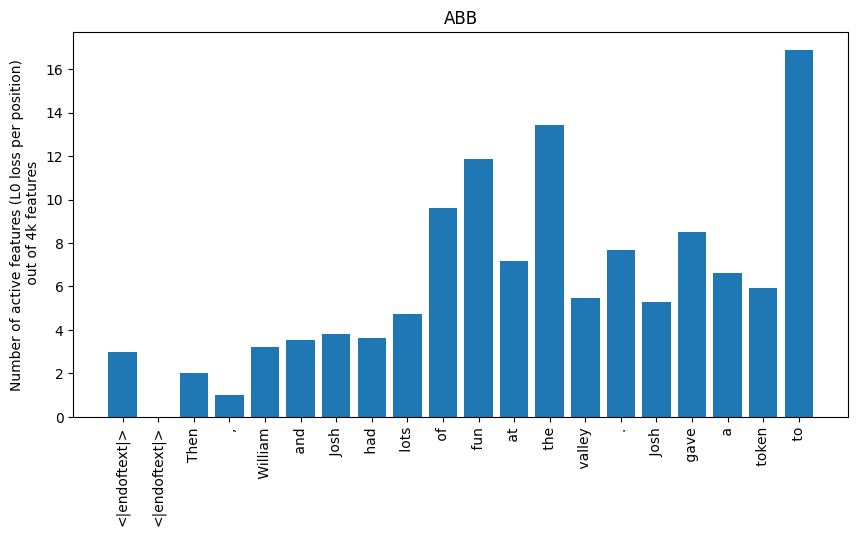

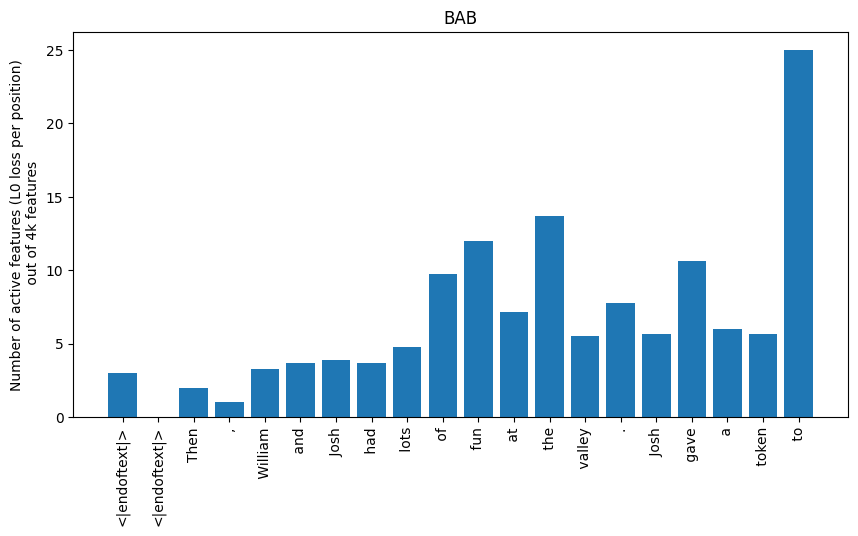

In [207]:
import matplotlib.pyplot as plt

# barplot
plt.figure(figsize=(10, 5))
plt.bar(range(abb_l0_per_pos.shape[0]), abb_l0_per_pos.cpu().numpy())
ex_text = model.to_str_tokens(ioi_tokens[0])
plt.xticks(range(abb_l0_per_pos.shape[0]), [model.tokenizer.bos_token] + ex_text, rotation=90)
plt.ylabel('Number of active features (L0 loss per position)\n out of 4k features')
plt.title('ABB')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(bab_l0_per_pos.shape[0]), bab_l0_per_pos.cpu().numpy())
ex_text = model.to_str_tokens(ioi_tokens[0])
plt.xticks(range(bab_l0_per_pos.shape[0]), [model.tokenizer.bos_token] + ex_text, rotation=90)
plt.ylabel('Number of active features (L0 loss per position)\n out of 4k features')
plt.title('BAB')
plt.show()

# Systematic Analysis of Queries l9h9

In [8]:
from tqdm import tqdm

def get_alive_neurons(encoder, activation_loader, n_activations=1e6, threshold=1e-6):
    n_batches = n_activations // encoder.cfg['batch_size'] - 1
    n_active_per_neuron = torch.zeros(encoder.cfg['d_hidden']).cuda()
    n_total = 0
    for i, batch in tqdm(enumerate(activation_loader)):
        batch = batch.cuda()
        feature_acts = encoder.encoder(batch) # [batch, d_hidden]
        n_active_per_neuron += (feature_acts > 1e-7).sum(dim=0)
        n_total += feature_acts.shape[0]
        if i >= n_batches:
            break
    frequencies = n_active_per_neuron / n_total
    # get indices of neurons that are more active than threshold
    indices = torch.where(frequencies > threshold)
    return indices[0]

In [9]:
from activation_buffer import Buffer

cfg['buffer_size'] = 1e6
buffer = Buffer(
    model.cuda(),
    text_dataset_loader,
    **encoder.cfg
)

Moving model to device:  cuda
setting up now
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to 

In [10]:
idx_alive = get_alive_neurons(encoder, buffer)
print('% of neurons alive: ', len(idx_alive) / encoder.cfg['d_hidden'])

461it [00:01, 467.03it/s]

new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch ad

461it [00:19, 467.03it/s]

new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch added to buffer
new batch ad

487it [00:33, 14.53it/s] 

new batch added to buffer
% of neurons alive:  0.739990234375


In [12]:
def get_ioi_neurons(encoder, ioi_loader, n_activations=1e6, threshold=1e-6):
    n_batches = n_activations // encoder.cfg['batch_size'] - 1
    n_active_per_neuron = torch.zeros(encoder.cfg['d_hidden']).cuda()
    n_total = 0
    for i, batch in tqdm(enumerate(ioi_loader)):
        batch = batch.cuda()
        _, cache = model.run_with_cache(batch)
        actv = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]  # activations at END token of IOI prompts
        feature_acts = encoder.encoder(actv) # [batch, d_hidden]
        n_active_per_neuron += (feature_acts > 1e-7).sum(dim=0)
        n_total += feature_acts.shape[0]
        if i >= n_batches:
            break
    frequencies = n_active_per_neuron / n_total
    # get indices of neurons that are more active than threshold
    indices = torch.where(frequencies > threshold)
    return indices[0]

In [18]:
idx_ioi_features = get_ioi_neurons(encoder, ioi_loader)
print('% of alive neurons that fire on END token of IOI prompts: ', len(idx_ioi_features) / len(idx_alive))
print('Number of neurons that fire on END token of IOI prompts: ', len(idx_ioi_features))

250it [00:19, 12.72it/s]

% of alive neurons that fire on END token of IOI prompts:  0.05146816232266579
Number of neurons that fire on END token of IOI prompts:  312


In [19]:
assert 2825 in idx_ioi_features

## Metrics I wanna track

* for each S name and feature, calculate attn difference for ABB, BAB, ABA, BBA separately, calculate such that attending to the correct name makes it positive
* for each IO name and feature, calculate attn difference for ABB, BAB, ABA, BBA separately, calculate such that attending to the correct name makes it positive
* for each name, calc if a feature is active if the name is S
* for each name, calc if a feature is active if the name is IO
* for each feature, calc if it only fires if S is at first or second position, averaged over all names

In [ ]:
cosine_sim(encoder.W_dec[idx_ioi_features], )

In [21]:
import joblib

codes = joblib.load('data/georg_codes_dict_webtext.joblib')
names = joblib.load('data/names.joblib')

In [22]:
z_l9h9 = codes[('z', 9, 9)]
q_l9h9 = codes[('q', 9, 9)]

In [23]:
def cosine_sim(dict_v, name_v):
    ab = einops.einsum(dict_v, name_v, 'd_hidden d_head, n_names d_head -> d_hidden n_names')
    # dict_v all have unit norm
    name_norm = name_v.norm(dim=-1)
    return ab / name_norm

In [27]:
tokens = model.to_tokens('Then, Robert and Nora had a long and really crazy argument. Afterwards, Nora said to', prepend_bos=True)
feature_id = 2825
# let's test the metrics with this prompt first before using all

In [25]:
n1_idx, n2_idx, n3_idx, end_idx = 3, 5, 16, 18

In [51]:
import random

names_filter = lambda name_: encoder.cfg['actv_name'] in name_

def io_pos_score(feature_idx, template_tokens, names, n1_idx, n2_idx, n3_idx, end_idx, n_random_samples = 10):
    # random samples: test a random combination of names rather than all as all would take too long
    score = torch.zeros_like(feature_idx).float()
    n_examples = 0
    for n1 in tqdm(random.sample(names, n_random_samples)):
        for n2 in random.sample(names, n_random_samples):
            for n3 in [n1, n2]:
                template_tokens[0, n1_idx] = model.to_single_token(' ' + n1)
                template_tokens[0, n2_idx] = model.to_single_token(' ' + n2)
                template_tokens[0, n3_idx] = model.to_single_token(' ' + n3)
                _, cache = model.run_with_cache(template_tokens, names_filter=names_filter)
                actv = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]  # activations at END token of IOI prompts
                feature_acts = encoder.encoder(actv) # [batch, d_hidden]
                feature_acts = feature_acts[:, feature_idx]
                # if ABB
                if n2 == n3:
                    score += feature_acts.sum(dim=0)
                else:
                    score -= feature_acts.sum(dim=0)
                n_examples += feature_acts.shape[0]
    return score / n_examples

In [54]:
io_pos_scores = io_pos_score(idx_ioi_features, tokens, names, n1_idx, n2_idx, n3_idx, end_idx)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.34it/s]


In [55]:
io_pos_scores[2825 == idx_ioi_features]

tensor([0.0146], device='cuda:0')

In [ ]:
# def get_per_src_pos_dfa_all_heads(tokens, feature_id, encoder, model):
feature_id = 2825
_, cache = model.run_with_cache(tokens)
layer = encoder.cfg["layer"]
#q = cache["q", layer] # [batch, src_pos, n_heads, d_head]
q = cache[encoder.cfg['actv_name']][:, :, encoder.cfg['head'], :]
encoder.encoder(q)[:, :, 2825] # batch seq_pos feature
k = cache["k", layer] # [batch, src_pos, n_heads, d_head]
if type(encoder.cfg['head']) == int:
    k_cat = k[:, :, encoder.cfg['head'], :]
    feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]][:, :, encoder.cfg['head']])[..., feature_id]
else:
    k_cat = einops.rearrange(v, "batch src_pos n_heads d_head -> batch src_pos (n_heads d_head)") # [batch, src_pos, n_heads*d_head]
    feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]])[..., feature_id]

scaled_dict_vectors = einops.einsum(feature_acts_per_pos, encoder.W_dec[feature_id], "batch pos, d_model -> batch pos d_model")
print(scaled_dict_vectors.shape)
per_src_pos_dfa = einops.einsum(k_cat, scaled_dict_vectors, "batch src_pos d_model, batch dest_pos d_model -> batch dest_pos src_pos")
## add autoregressive attention mask
seq_len = per_src_pos_dfa.shape[1]
mask = torch.tril(torch.ones(seq_len, seq_len), diagonal=1).to(per_src_pos_dfa.device)
per_src_pos_dfa = per_src_pos_dfa * mask# * -1
#return per_src_pos_dfa

In [175]:
import random
import pandas as pd

names_filter = lambda name_: encoder.cfg['actv_name'] in name_

def io_pos_score(feature_idx, template_tokens, test_name, names, n1_idx, n2_idx, n3_idx, end_idx, n_random_samples = 10, mode='count'):
    # random samples: test a random combination of names rather than all as all would take too long
    # mode: count or sum. count: count (in percent) how many times the feature is active, sum: sum the attention contributions directly
    df = pd.DataFrame(data={
        'abb': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'bab': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'aba': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'baa': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'abb_perf': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'bab_perf': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'aba_perf': torch.zeros_like(feature_idx).float().cpu().numpy(),
        'baa_perf': torch.zeros_like(feature_idx).float().cpu().numpy(),
    })
    n_examples = 0
    for n_pos in [0, 1]:
        for n in names:
            if n_pos == 0:
                n1, n2 = test_name, n
            else:
                n1, n2 = n, test_name
            for n3 in [n1, n2]:
                template_tokens[0, n1_idx] = model.to_single_token(' ' + n1)
                template_tokens[0, n2_idx] = model.to_single_token(' ' + n2)
                template_tokens[0, n3_idx] = model.to_single_token(' ' + n3)
                _, cache = model.run_with_cache(template_tokens)
                actv = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]  # activations at END token of IOI prompts
                feature_acts = encoder.encoder(actv) # [batch, d_hidden]
                feature_acts = feature_acts[:, feature_idx]
                act_score = (feature_acts > 0).sum(dim=0).cpu().numpy()
                
                # get keys for END position
                k = cache["k", encoder.cfg['layer']] # [batch, src_pos, n_heads, d_head]
                if type(encoder.cfg['head']) == int:
                    k_cat = k[:, :, encoder.cfg['head'], :]
                    feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]][:, -1, encoder.cfg['head']])[..., feature_idx]
                else:
                    k_cat = einops.rearrange(v, "batch src_pos n_heads d_head -> batch src_pos (n_heads d_head)") # [batch, src_pos, n_heads*d_head]
                    feature_acts_per_pos = encoder.encoder(cache[encoder.cfg["actv_name"]])[:, -1, feature_idx]
                # k_cat = batch x pos x d_head
                # feature_acts_per_pos = batch x n_features
                    
                # calculate attn difference
                scaled_dict_vectors = einops.einsum(feature_acts_per_pos, encoder.W_dec[feature_idx], "batch n_features, n_features d_head -> batch n_features d_head")
                per_src_pos_dfa = einops.einsum(k_cat, scaled_dict_vectors, "batch pos d_head, batch n_features d_head -> batch pos n_features")
                
                if n2 == n3:
                    diff = per_src_pos_dfa[:, n1_idx] - per_src_pos_dfa[:, n2_idx] # batch x n_features
                else:
                    diff = per_src_pos_dfa[:, n2_idx] - per_src_pos_dfa[:, n1_idx] # batch x n_features
                
                if mode == 'count':
                    diff = diff > 0
                elif mode == 'sum':
                    pass
                else:
                    raise ValueError('mode must be count or sum')
                
                perf_score = diff.sum(dim=0).cpu().numpy()
                
                # if ABB or ABA
                if n1 == test_name:
                    if n3 == n1: # ABA
                        df['aba'] += act_score
                        df['aba_perf'] += perf_score
                    else: # ABB
                        df['abb'] += act_score
                        df['abb_perf'] += perf_score
                # if BAB or BBA
                else:
                    if n3 == n1: # BAB
                        df['bab'] += act_score
                        df['bab_perf'] += perf_score
                    else: # BBA
                        df['baa'] += act_score
                        df['baa_perf'] += perf_score
                n_examples += feature_acts.shape[0]
    return df / (n_examples // 4)

# io_pos_scores = io_pos_score(idx_ioi_features, tokens, test_name='Robert', names=names, n1_idx=n1_idx, n2_idx=n2_idx, n3_idx=n3_idx, end_idx=end_idx)

In [176]:
df = pd.DataFrame()
for test_name in tqdm(names[:10]):
    io_pos_scores = io_pos_score(idx_ioi_features, tokens, test_name, names, n1_idx, n2_idx, n3_idx, end_idx)
    io_pos_scores['feature'] = idx_ioi_features.cpu().numpy()
    io_pos_scores['name'] = test_name
    df = pd.concat([df, io_pos_scores])
# save df
df.to_csv('io_pos_scores.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:55<00:00, 53.51s/it]


In [177]:
df['contains_name'] = df['abb'] * df['aba'] * df['bab'] * df['baa']
df['is_subject'] = df['aba'] * df['baa'] - (df['bab'] + df['abb'])
df['is_io'] = df['bab'] * df['abb'] - (df['aba'] + df['baa'])
df['io_pos_first'] = df['abb'] * df['baa'] - (df['aba'] + df['bab'])
df['io_pos_second'] = df['bab'] * df['aba'] - (df['abb'] + df['baa'])
df['name_is_first'] = df['aba'] * df['abb'] - (df['bab'] + df['baa'])
df['name_is_second'] = df['bab'] * df['baa'] - (df['aba'] + df['abb'])
df['name_is_first_and_subject'] = df['aba'] - (df['abb'] + df['bab'] + df['baa'])
df['name_is_second_and_subject'] = df['baa'] - (df['abb'] + df['bab'] + df['aba'])
df['name_is_first_and_io'] = df['abb'] - (df['aba'] + df['bab'] + df['baa'])
df['name_is_second_and_io'] = df['bab'] - (df['abb'] + df['aba'] + df['baa'])

In [186]:
print('contains name', (df['contains_name'] > 0.25).sum() / len(df.name.unique()))
print('is subject', (df['is_subject'] > 0.25).sum() / len(df.name.unique()))
print('is io', (df['is_io'] > 0.25).sum() / len(df.name.unique()))
print('io_pos_first', (df['io_pos_first'] > 0.25).sum() / len(df.name.unique()))
print('io_pos_second', (df['io_pos_second'] > 0.25).sum() / len(df.name.unique()))
print('name_is_first', (df['name_is_first'] > 0.25).sum() / len(df.name.unique()))
print('name_is_second', (df['name_is_second'] > 0.25).sum() / len(df.name.unique()))
print('name_is_first_and_subject', (df['name_is_first_and_subject'] > 0.25).sum() / len(df.name.unique()))
print('name_is_second_and_subject', (df['name_is_second_and_subject'] > 0.25).sum() / len(df.name.unique()))
print('name_is_first_and_io', (df['name_is_first_and_io'] > 0.25).sum() / len(df.name.unique()))
print('name_is_second_and_io', (df['name_is_second_and_io'] > 0.25).sum() / len(df.name.unique()))

contains name 8.9
is subject 0.2
is io 0.3
io_pos_first 2.8
io_pos_second 8.0
name_is_first 0.0
name_is_second 0.0
name_is_first_and_subject 6.6
name_is_second_and_subject 1.8
name_is_first_and_io 2.3
name_is_second_and_io 3.2


In [195]:
for n in names[:10]:
    print(n, df.loc[(df.io_pos_second > 0.3) & (df.name==n) & (df.name_is_first_and_subject > 0.25), 'feature'].unique())

Sebastian [2277 3248 8162]
Jack []
Jeremiah [ 957 2277 8162]
Ellie [ 957 2277 6728]
Sean [ 957 2277 6728]
William [ 957 1125 2277 3248 6728 8162]
Caroline [6728]
Cooper [3248 5666]
Xavier []
Ian [ 957 2277 3581 6728 8162]


In [191]:
df.loc[(df.io_pos_second > 0.3) & (df.name==names[1]), 'feature']

235    6328
250    6644
280    7272
Name: feature, dtype: int64

In [190]:
names[0]

'Sebastian'

In [217]:
df[df.name == 'Sebastian']

,abb,bab,aba,baa,abb_perf,bab_perf,aba_perf,baa_perf,feature,name,...,is_subject,is_io,io_pos_first,io_pos_second,name_is_first,name_is_second,name_is_first_and_subject,name_is_second_and_subject,name_is_first_and_io,name_is_second_and_io
0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,24,Sebastian,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,36,Sebastian,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,44,Sebastian,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,64,Sebastian,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,68,Sebastian,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,8056,Sebastian,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
308,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,8107,Sebastian,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
309,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,8140,Sebastian,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
310,0.00000,0.328704,1.013889,0.000000,0.00000,0.217593,0.796296,0.000000,8162,Sebastian,...,-0.328704,-1.013889,-1.342593,0.333269,-0.328704,-1.013889,0.685185,-1.342593,-1.342593,-0.685185


# what features are active in this prompt:
* this prompt is A B A -> B
* 383: makes ABB and BAA more likely but is always active
* 555: makes BAB and ABA more likely but is always active
* 651: makes everything more likely but is always active (but especially abb and bab, so this might be "look at name a" feature)
* 2060: doesn't do much
* 2277: makes bab and aba more likely
* 2852: makes abb and baa more likely and a bit bab but is always active
* 3248: says io is at second position (and name is Sebastian)
* 3581: same !
* 5608: nothing
* 5610: bab and aba, always active

In [216]:
tokens = model.to_tokens('Then, Sebastian and Nora had a long and really crazy argument. Afterwards, Sebastian said to', prepend_bos=True)
_, cache = model.run_with_cache(tokens)
actv = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]  # activations at END token of IOI prompts
feature_acts = encoder.encoder(actv) # [batch, d_hidden]
feature_acts = feature_acts[:, idx_ioi_features]
# list of features that are active
idx_ioi_features[feature_acts.sum(dim=0) > 0]

tensor([ 383,  555,  651, 2060, 2277, 2825, 3248, 3581, 5608, 5610, 6229, 6328,
        6367, 6524, 6553, 6644, 7272, 7865, 8162], device='cuda:0')

In [66]:
io_pos_scores[2825 == idx_ioi_features]

tensor([0.0057], device='cuda:0')

In [210]:
cosine_sim(encoder.W_dec[4385].view(1, -1), q_l9h9[('io_pos',)][0].view(1, -1))

tensor([[0.5760]], device='cuda:0')

In [213]:
cosine_sim(encoder.W_dec, q_l9h9[('io_pos',)][0].view(1, -1)).max()

tensor(0.5760, device='cuda:0')

<Axes: xlabel='feature', ylabel='bab'>

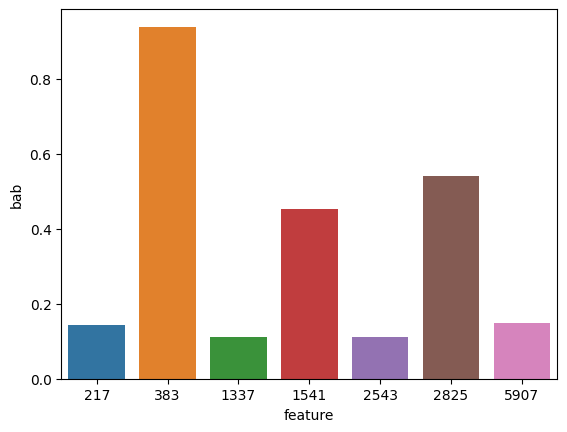

In [155]:
io_pos_scores['feature'] = idx_ioi_features.cpu().numpy()
x = io_pos_scores.loc[io_pos_scores['bab'] > 0.1, 'feature']
y = io_pos_scores.loc[io_pos_scores['bab'] > 0.1, 'bab']
sns.barplot(x=x, y=y)

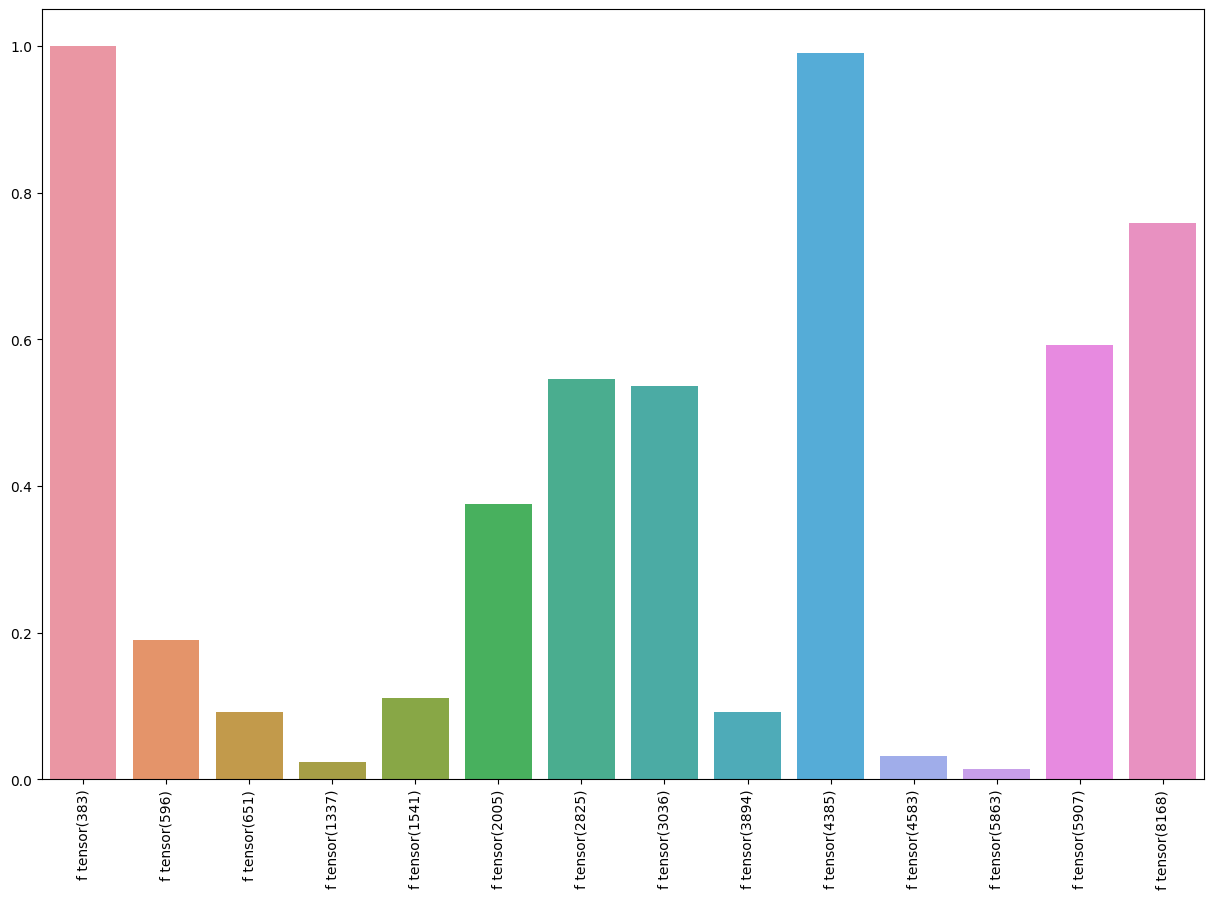

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
x = np.array(['f ' + str(a) for a in idx_ioi_features.cpu()])
y = io_pos_scores.cpu().numpy()
x = x[y>0.01]
y = y[y>0.01]
sns.barplot(x=x, y=y)
# rotate x labels
plt.xticks(rotation=90)
plt.show()

In [93]:
x[(y > 0.1).astype(bool)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [124]:
x

array([], dtype='<U14')

In [75]:
str(idx_ioi_features)

"tensor([  24,   36,   44,   64,   68,   99,  141,  161,  182,  217,  266,  298,\n         334,  365,  383,  390,  463,  480,  555,  570,  587,  596,  600,  613,\n         625,  651,  687,  736,  751,  811,  816,  861,  917,  957,  968,  980,\n         996, 1033, 1073, 1100, 1125, 1221, 1224, 1322, 1337, 1342, 1382, 1391,\n        1401, 1421, 1430, 1493, 1540, 1541, 1653, 1689, 1736, 1753, 1803, 1872,\n        1881, 1914, 1938, 1961, 2005, 2011, 2013, 2056, 2060, 2062, 2073, 2102,\n        2115, 2131, 2177, 2179, 2204, 2206, 2235, 2277, 2351, 2377, 2380, 2408,\n        2535, 2543, 2568, 2585, 2596, 2615, 2616, 2617, 2620, 2625, 2715, 2770,\n        2797, 2825, 2909, 2947, 2968, 3009, 3036, 3043, 3106, 3117, 3145, 3177,\n        3248, 3275, 3319, 3338, 3364, 3406, 3435, 3436, 3519, 3536, 3552, 3569,\n        3581, 3589, 3608, 3624, 3684, 3701, 3744, 3765, 3792, 3856, 3894, 3905,\n        3950, 4003, 4030, 4033, 4074, 4085, 4091, 4097, 4215, 4251, 4264, 4299,\n        4319, 4348, 4376, 4

In [69]:
dead_neurons = torch.zeros(cfg['d_hidden']).cuda()

for batch in ioi_loader:
    # prepend bos
    batch = batch[:10]
    batch = torch.cat([torch.full((batch.shape[0], 1), 50256, device=batch.device, dtype=batch.dtype), batch], dim=1)
    _, cache = model.run_with_cache(batch.cuda(), names_filter=names_filter)
    z = cache[encoder.cfg['actv_name']][:, -1, cfg['head'], :]
    feature_acts = encoder.encoder(z) # [batch, seq, d_hidden]
    dead_neurons += (feature_acts > 1e-7).sum(dim=[0])

    i += 1
    if i > 1000:
        break
ioi_features = torch.topk(dead_neurons, 20)
features = ioi_features.indices
ioi_features.values, features

(tensor([2459., 2415., 2367., 2023., 1951., 1854., 1801., 1711., 1708., 1431.,
         1392., 1384., 1235., 1152., 1102., 1102., 1044.,  989.,  964.,  921.],
        device='cuda:0'),
 tensor([ 555,  383, 2825, 6553, 5608, 5610, 5167, 1541, 6328, 2543,  651, 7865,
         6644, 4385,  596, 6524, 7272, 3248,  811, 6367], device='cuda:0'))

In [42]:
encoder.standard_norm

Parameter containing:
tensor(9, device='cuda:0')

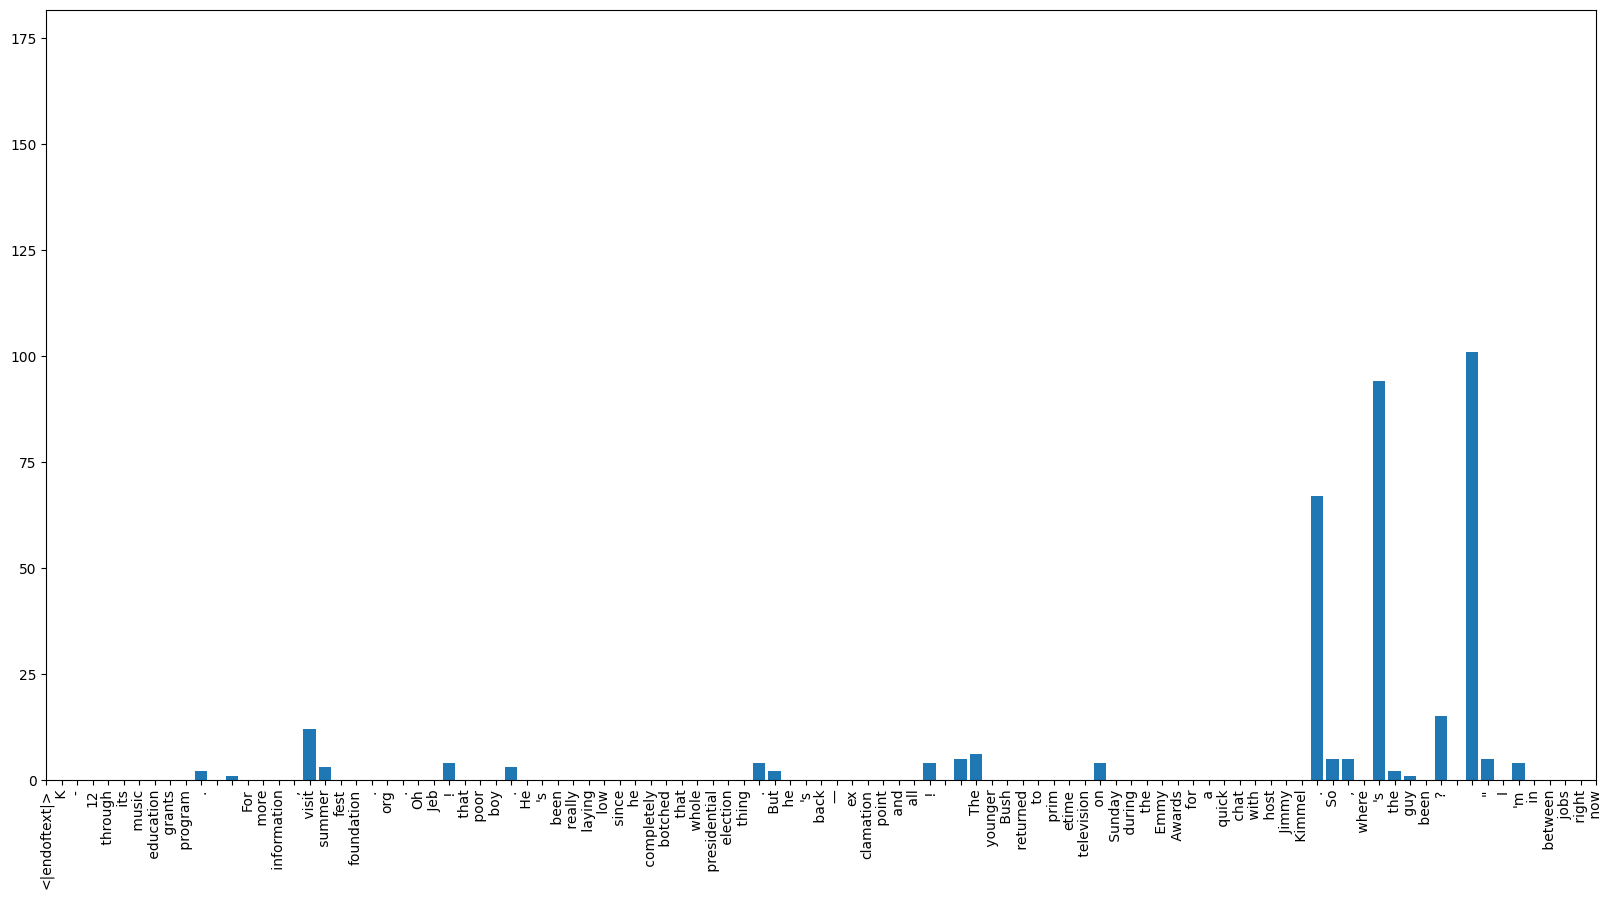

In [52]:
batch = next(iter(text_dataset_loader))#ioi_loader:
# prepend bos
batch = batch[:1]
batch = torch.cat([torch.full((batch.shape[0], 1), 50256, device=batch.device, dtype=batch.dtype), batch], dim=1)
_, cache = model.run_with_cache(batch.cuda())
z = cache[encoder.cfg['actv_name']][:, :, cfg['head'], :]
feature_acts = encoder.encoder(z) # [batch, seq,

plt.figure(figsize=(20, 10))
plt.bar(range(encoder.cfg['seq_len'] + 1), (feature_acts > 1e-7).sum(dim=[0, 2]).cpu().numpy())
ex_text = model.to_str_tokens(batch[0])
plt.xticks(range(encoder.cfg['seq_len'] + 1), ex_text, rotation=90)
plt.xlim(0, 100)
plt.show()

In [19]:
(feature_acts > 1e-7).sum(dim=[0, 2])

torch.Size([129])

In [64]:
new_state_dict = {
    'W_enc': encoder.state_dict()['encoder_map.weight'],
    'b_enc': encoder.state_dict()['encoder_map.bias'],
    'W_dec': encoder.state_dict()['decoder_map.weight'],
    'b_dec': encoder.state_dict()['tied_bias'],
}
new_state_dict

{'W_enc': tensor([[ 0.0573, -0.2218,  0.0162,  ...,  0.2301,  0.2309,  0.0581],
         [ 0.1115, -0.0929, -0.0451,  ...,  0.0452, -0.1430, -0.0537],
         [-0.0038, -0.0015, -0.0018,  ..., -0.0005,  0.0003, -0.0003],
         ...,
         [-0.0408, -0.1059, -0.0744,  ...,  0.0898, -0.0918, -0.0255],
         [-0.0003,  0.0367,  0.0508,  ..., -0.1006, -0.0693, -0.0803],
         [-0.1066,  0.0024, -0.0403,  ..., -0.0681, -0.0713,  0.0407]]),
 'b_enc': tensor([-3.1968, -3.0671, -0.0919,  ..., -1.8058, -3.0700, -1.2074]),
 'W_dec': tensor([[ 0.1483,  0.1209,  0.2336,  ..., -0.0657,  0.0452, -0.1908],
         [-0.1656,  0.0571,  0.0890,  ..., -0.0793,  0.0640, -0.0303],
         [-0.0010, -0.1732,  0.0830,  ..., -0.1400, -0.0087, -0.0632],
         ...,
         [ 0.1635,  0.0835,  0.0703,  ...,  0.1997, -0.1610, -0.1004],
         [ 0.1941, -0.1332,  0.0469,  ..., -0.2192, -0.0414, -0.1608],
         [ 0.1131, -0.0185, -0.0550,  ..., -0.0378,  0.0233,  0.1067]]),
 'b_dec': tensor([

In [16]:
#q_l9h9 = codes[78]
#z_l9h9 = codes[79]

In [13]:
cosine_sim(encoder.W_dec, q_l9h9[('io',)]).min(), cosine_sim(encoder.W_dec, q_l9h9[('io',)]).max()

(tensor(-0.7826, device='cuda:0'), tensor(0.8010, device='cuda:0'))

In [ ]:
cosine_sim(encoder.W_dec, q_l9h9[('io',)]).min(), cosine_sim(encoder.W_dec, q_l9h9[('io',)]).max()


In [14]:
cosine_sim(encoder.W_dec, q_l9h9[('s',)]).min(), cosine_sim(encoder.W_dec, q_l9h9[('s',)]).max()

(tensor(-0.6780, device='cuda:0'), tensor(0.6814, device='cuda:0'))

In [102]:
cosine_sim(encoder.W_dec[2825].view(1, -1), q_l9h9[('io_pos',)][1].view(1, -1))

tensor([[-0.0844]], device='cuda:0')

In [114]:
torch.topk(cosine_sim(encoder.W_dec[2825].view(1, -1), q_l9h9[('io',)]), 10)


torch.return_types.topk(
values=tensor([[0.4213, 0.4076, 0.3973, 0.3883, 0.3854, 0.3757, 0.3461, 0.3407, 0.3231,
         0.3114]], device='cuda:0'),
indices=tensor([[ 54,   8, 167,  66,  77,  80, 188, 108, 204, 106]], device='cuda:0'))

In [124]:
names[106]

'Christian'

In [86]:
encoder.W_dec[16].shape

torch.Size([64])

In [41]:
biggest = torch.topk(cosine_sim(encoder.W_dec, z_l9h9[('io_pos',)][1].view(1, -1)).flatten(), 20)
features = biggest.indices
biggest.values
features

tensor([3839, 3948,  738, 7918, 5204, 4430, 6589, 5465, 5956, 7956, 4876, 4027,
        2862, 5097, 3070, 1837, 1673, 4050, 6193, 6066], device='cuda:0')

In [119]:
rows, cols = cosine_sim(encoder.W_dec, z_l9h9[('io',)]).shape
row_index = biggest // cols
col_index = biggest % cols
row_index, col_index

(tensor(5763, device='cuda:0'), tensor(60, device='cuda:0'))

In [121]:
names[col_index]

'James'

Text(0.5, 1.0, 'Cosine similarity between every ground truth IO name feature \nand the closest feature in the dictionary')

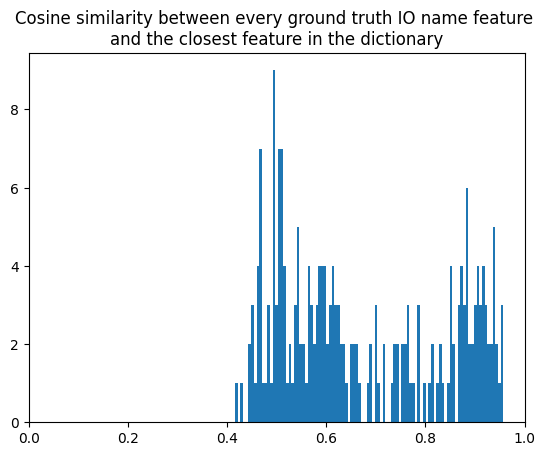

In [87]:
plt.hist(torch.max(cosine_sim(encoder.W_dec, z_l9h9[('io',)]), dim=0).values.cpu(), bins=100)
plt.xlim(0, 1)
plt.title('Cosine similarity between every ground truth IO name feature \nand the closest feature in the dictionary')

In [34]:
a_rand = torch.randn_like(encoder.W_dec)
a_rand = a_rand / a_rand.norm(dim=-1, keepdim=True)
cosine_sim(a_rand, torch.randn_like(q_l9h9['codes'][('s',)])).min()

tensor(-0.5555, device='cuda:0')

In [81]:
sims = cosine_sim(encoder.W_dec, z_l9h9[('s',)][5].view(1, -1))
sims.shape

torch.Size([4096, 1])

In [82]:
sims.argmax(), sims.argmin()

(tensor(694, device='cuda:0'), tensor(1207, device='cuda:0'))

In [89]:
sims.max()

tensor(0.4240, device='cuda:0')

In [84]:
features = [694, 1207]

In [83]:
sims[:10]

tensor([[ 0.1707],
        [-0.0593],
        [-0.1351],
        [-0.0223],
        [ 0.0226],
        [ 0.0952],
        [ 0.2323],
        [-0.1879],
        [ 0.0817],
        [ 0.2068]], device='cuda:0')

In [43]:
'Jen' in codes[0]['names']

True

In [79]:
# which position is Jen?
names.index('William')

5

In [28]:
encoder.cfg

{'lr': 0.001,
 'head': 9,
 'layer': 9,
 'seq_len': 512,
 'd_hidden': 4096,
 'actv_name': 'blocks.9.attn.hook_z',
 'actv_size': 64,
 'ckpt_name': 'z-l9h9-40M-l1_7e-3.ckpt',
 'batch_size': 2048,
 'wandb_name': 'z-l9h9_l1_7e-3_40M_geom_median',
 'buffer_size': 1000000.0,
 'train_steps': 20000,
 'dataset_name': 'Skylion007/openwebtext',
 'l1_coefficient': 0.007,
 'lr_warmup_steps': 3000,
 'resampling_steps': [50000, 100000, 150000, 200000],
 'n_resampler_samples': 819200,
 'extraction_batch_size': 20,
 'init_geometric_median': True,
 'standardize_activations': False,
 'n_resampling_watch_steps': 5000,
 'reconstruction_loss_batch_size': 16,
 'concat_heads': False}